<a href="https://colab.research.google.com/github/MatthewC00273575/Data-Science/blob/master/Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# Load red and white wine datasets
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')
data = pd.concat([red, white], ignore_index=True)

# Binarize quality: <6 is 'bad' (0), >=6 is 'good' (1)
data['quality'] = (data['quality'] >= 6).astype(int)
X = data.drop('quality', axis=1)  # 11 numerical features
y = data['quality']

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")
print(data['quality'].value_counts())

Training samples: 5197, Features: 11
quality
1    4113
0    2384
Name: count, dtype: int64


In [ ]:
# scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Baseline SVM with linear kernel
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

print(f"Linear SVM Accuracy: {accuracy_score(y_test, y_pred_linear):.3f}")
# Expected: ~0.70-0.75 (linear separation is decent but not perfect)

Linear SVM Accuracy: 0.731


In [ ]:
# SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print(f"RBF SVM Accuracy: {accuracy_score(y_test, y_pred_rbf):.3f}")
# Expected: ~0.80-0.85 (RBF captures nonlinearities better)

RBF SVM Accuracy: 0.762


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Explained variance (how much info we keep)
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")


Explained variance ratio: 0.502


In [ ]:
# Linear SVM on 2D
svm_linear_2d = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear_2d.fit(X_train_2d, y_train)

# RBF SVM on 2D
svm_rbf_2d = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf_2d.fit(X_train_2d, y_train)

# Quick accuracy check (will be lower due to PCA)
print(f"2D Linear Accuracy: {svm_linear_2d.score(X_test_2d, y_test):.3f}")
print(f"2D RBF Accuracy: {svm_rbf_2d.score(X_test_2d, y_test):.3f}")
# Expected: ~0.65-0.70 (loss from PCA, but still shows kernel effect)

2D Linear Accuracy: 0.653
2D RBF Accuracy: 0.687


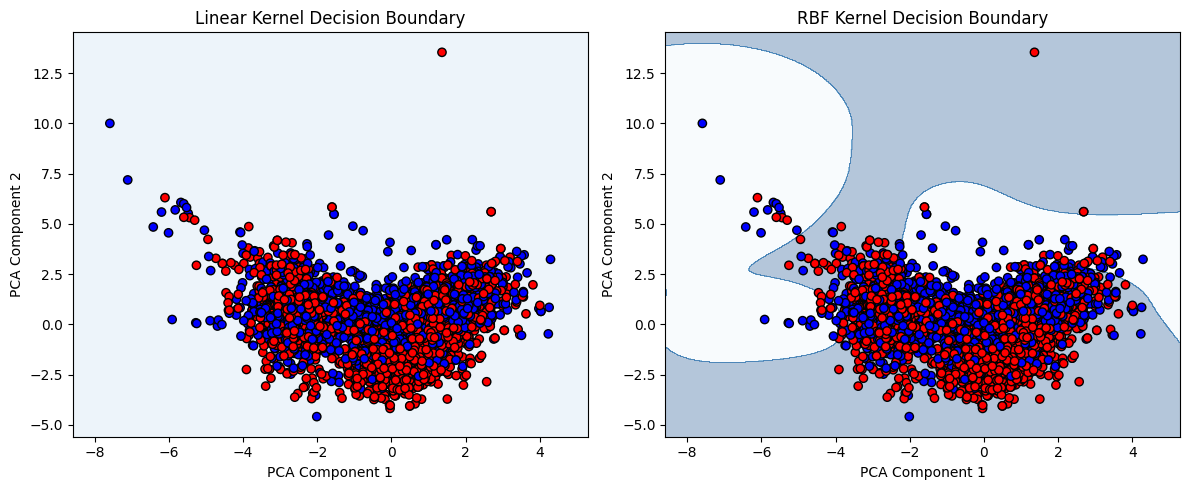

In [ ]:
# Create meshgrid for decision boundary
h = 0.02  # Step size
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict over grid for both models
Z_linear = svm_linear_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)

Z_rbf = svm_rbf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 5))

# Linear kernel
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_linear, cmap='Blues', alpha=0.3)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='bwr', edgecolors='k')
plt.title('Linear Kernel Decision Boundary')
plt.xlabel('PCA Component 1'); plt.ylabel('PCA Component 2')

# RBF kernel
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_rbf, cmap='Blues', alpha=0.3)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap='bwr', edgecolors='k')
plt.title('RBF Kernel Decision Boundary')
plt.xlabel('PCA Component 1'); plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Tune C and gamma
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 'scale']}
grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)
print(f"Best Params: {grid_search.best_params_}")
print(f"Tuned Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")

Best Params: {'C': 10, 'gamma': 0.1}
Tuned Accuracy: 0.781


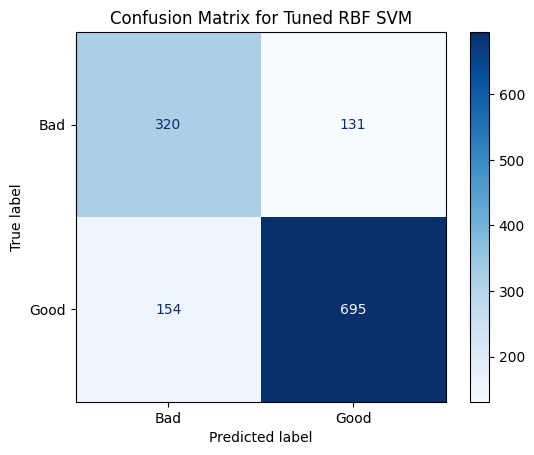

Tuned Accuracy: 0.781


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix for tuned model
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Tuned RBF SVM')
plt.show()

print(f"Tuned Accuracy: {accuracy_score(y_test, y_pred_best):.3f}")